In [1]:
from plot_trajectory import plot_paths
import training
import json
import torch
from torch.utils.data import DataLoader
from dataloader import load_val
import joblib
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from paths import RESULTS_FILTERED_DIR, RESULTS_UNFILTERED_DIR
from model_selection import rank_models, plot_model_losses, haversine_np
from configurations import find_cfg
from save_results import load_data, best_model, compute_MSE_per_sample, load_scaler, plot_sample
import pandas as pd
import pickle

In [2]:
device = training.determine_device()
print("Using device:", device)

Using device: cpu


In [3]:
metrics = ["val_mse", "val_rmse", "val_mae"]
best_model_name, best_score, best_model_data = rank_models(RESULTS_FILTERED_DIR, metrics[0])

Best validation MSE per model (sorted): 

1. small_seq2seq_trans            best MSE = 0.000431
2. mini_seq2seq_trans             best MSE = 0.000647
3. small_seq2seq_trans            best MSE = 0.000837
4. twolayer_seq2seq_trans         best MSE = 0.001039
5. medium_seq2seq_trans           best MSE = 0.001125
6. dropoutincrease_seq2seq_trans  best MSE = 0.001321
7. deep_seq2seq_trans             best MSE = 0.001887
8. deeper_autoreg_lstm_2          best MSE = 0.005887
9. deeper_autoreg_lstm            best MSE = 0.006013
10. medium_autoreg_lstm            best MSE = 0.006168
11. deeper_lstm_2                  best MSE = 0.006291
12. deeper_lstm                    best MSE = 0.006390
13. small_autoreg_lstm             best MSE = 0.006626
14. medium_lstm                    best MSE = 0.006685
15. small_lstm                     best MSE = 0.007034
16. deeper_transformer             best MSE = 0.007193
17. mini_lstm                      best MSE = 0.008681
18. mini_autoreg_lstm           

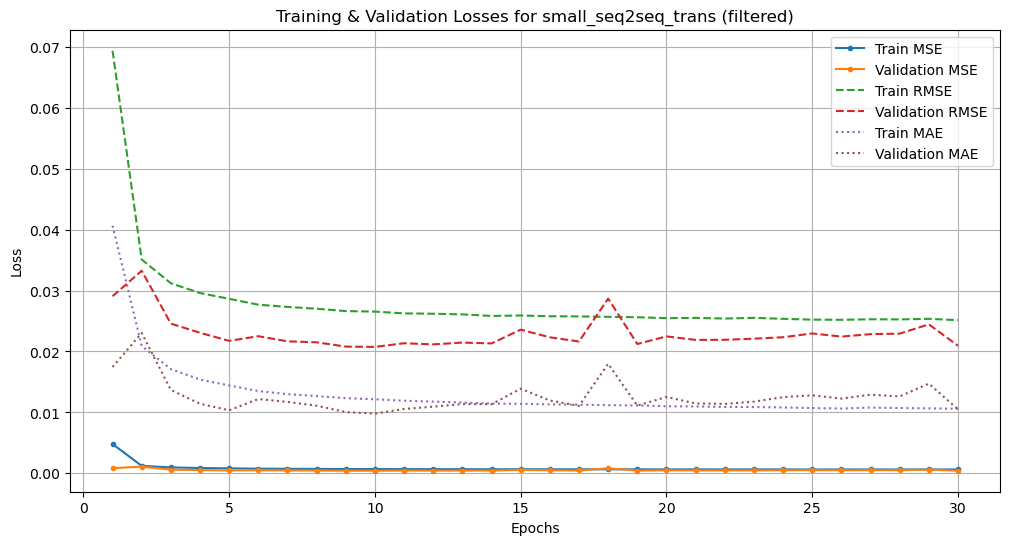

In [4]:
# plot losses for the best model based on MSE

plot_model_losses(best_model_data)

In [5]:
# Load the validation dataset
# TRUE for filtered data, FALSE  for unfiltered data

val_loader = load_data(validation=True, filtered=True)

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading VAL...


100%|██████████| 12847/12847 [00:24<00:00, 528.14it/s]


In [6]:
model = best_model(best_model_name, best_model_data, device=device, filtered=True)

In [7]:
model

Seq2SeqTransformer(
  (input_proj): Linear(in_features=2, out_features=16, bias=True)
  (pos_enc): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_a

In [8]:
save_results = compute_MSE_per_sample(model, val_loader, device=device, output_name=best_model_name)

Computing per-sample MSE: 100%|██████████| 868/868 [03:46<00:00,  3.83it/s]



 Saved small_seq2seq_trans_results.pkl


In [9]:
file_path = 'small_seq2seq_trans_results.pkl'

# Open the file in binary mode and load the data
with open(file_path, 'rb') as file:
    results = pickle.load(file)

print(results)

{'all_mse': array([1.9934749e-05, 1.4518815e-05, 1.0667948e-05, ..., 6.8603731e-05,
       3.5621160e-05, 1.4105784e-04], dtype=float32), 'x': array([[[-0.13287547, -1.3617427 ],
        [-0.13289897, -1.3617404 ],
        [-0.13291577, -1.3617605 ],
        ...,
        [-0.13849874, -1.3762388 ],
        [-0.13554779, -1.3708379 ],
        [-0.13740766, -1.3747755 ]],

       [[-0.13286205, -1.3617616 ],
        [-0.1328822 , -1.3617567 ],
        [-0.13288555, -1.3617692 ],
        ...,
        [-0.13604465, -1.3714519 ],
        [-0.13696787, -1.3718795 ],
        [-0.1335872 , -1.3665884 ]],

       [[-1.0181322 ,  0.53154767],
        [-1.0181725 ,  0.53154767],
        [-1.0181926 ,  0.5315843 ],
        ...,
        [-1.0165678 ,  0.53747296],
        [-1.0165678 ,  0.5374923 ],
        [-1.0165712 ,  0.5374845 ]],

       ...,

       [[ 0.6360518 , -1.8934973 ],
        [ 0.63126445, -1.8992561 ],
        [ 0.6264469 , -1.9052645 ],
        ...,
        [ 0.5199741 , -2.00826

In [10]:
all_mse = results["all_mse"]
x = results["x"]
y = results["y"]
y_pred = results["y_pred"]
n_samples = len(all_mse)
sorted_indices = np.argsort(all_mse)

In [11]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 99.99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")


MSE percentile summary:

 10% of samples have MSE ≤ 0.000031
 30% of samples have MSE ≤ 0.000095
 50% of samples have MSE ≤ 0.000204
 80% of samples have MSE ≤ 0.000864
 90% of samples have MSE ≤ 0.001661
 95% of samples have MSE ≤ 0.002815
 99% of samples have MSE ≤ 0.006932
99.99% of samples have MSE ≤ 0.330727
100% of samples have MSE ≤ 8.963919


In [12]:
scaler = load_scaler(filtered=True)

groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n_samples//4:n_samples//4+3],
    "Median": sorted_indices[n_samples//2:n_samples//2+3],
    "Q3": sorted_indices[3*n_samples//4:3*n_samples//4+3],
    "Worst": sorted_indices[-3:]
}

group_means_dict = {}

print("\n=== Haversine Distance Evaluation by Groups ===")

for group_name, indices in groups.items():
    group_means = []

    print(f"\n### {group_name} group ###")

    for idx in indices:

        y_true_scaled = y[idx]
        y_pred_scaled = y_pred[idx]


        y_true_unscaled = scaler.inverse_transform(y_true_scaled)
        y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

        # Compute Haversine
        dists_km, mean_hav_km = haversine_np(y_true_unscaled, y_pred_unscaled)

        # Save group mean
        group_means.append(mean_hav_km)

        # --- Pretty step-wise print for groups ---
        print(f"\nSample {idx} (MSE={all_mse[idx]:.6f}) – Haversine per step:")
        for step, d in enumerate(dists_km, start=1):
            print(f"  Step {step:02d} → {d:10.6f} km")

        print(f"  → Mean Haversine for this sample: {mean_hav_km:.6f} km")

        group_means_dict[group_name] = group_means


=== Haversine Distance Evaluation by Groups ===

### Best group ###

Sample 183464 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.124127 km
  Step 02 →   0.089047 km
  Step 03 →   0.067385 km
  Step 04 →   0.127000 km
  Step 05 →   0.079429 km
  Step 06 →   0.013018 km
  Step 07 →   0.091806 km
  Step 08 →   0.038764 km
  Step 09 →   0.178506 km
  Step 10 →   0.086622 km
  → Mean Haversine for this sample: 0.089570 km

Sample 4110 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.121042 km
  Step 02 →   0.158191 km
  Step 03 →   0.147978 km
  Step 04 →   0.162633 km
  Step 05 →   0.135536 km
  Step 06 →   0.108123 km
  Step 07 →   0.112165 km
  Step 08 →   0.194600 km
  Step 09 →   0.198334 km
  Step 10 →   0.104115 km
  → Mean Haversine for this sample: 0.144272 km

Sample 440328 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.146640 km
  Step 02 →   0.183773 km
  Step 03 →   0.121300 km
  Step 04 →   0.041735 km
  Step 05 →   0.081298 km
  Step 06 →   0.080769 km
  Ste

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Plotting 3 samples from Best group:


/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


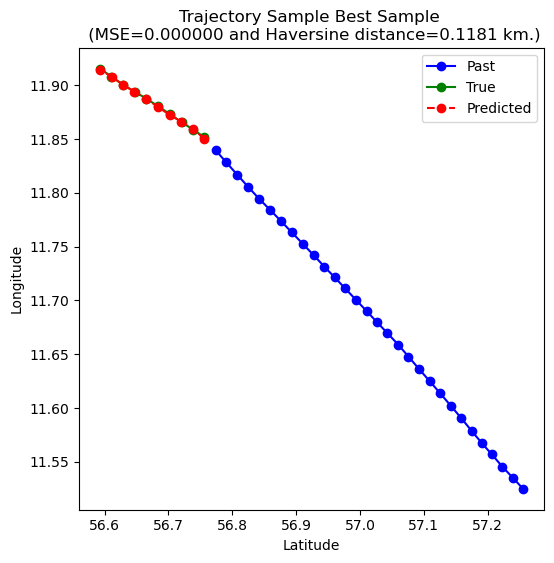

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


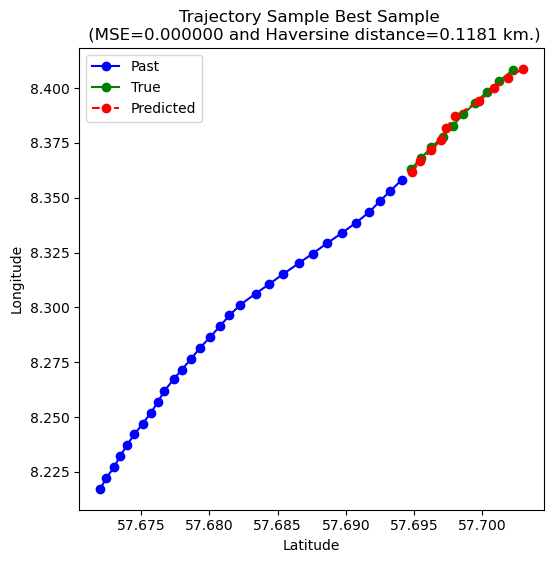

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


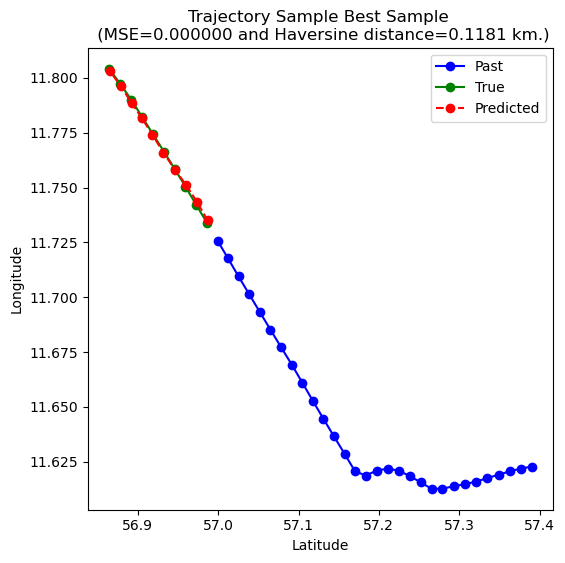

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Plotting 3 samples from Q1 group:


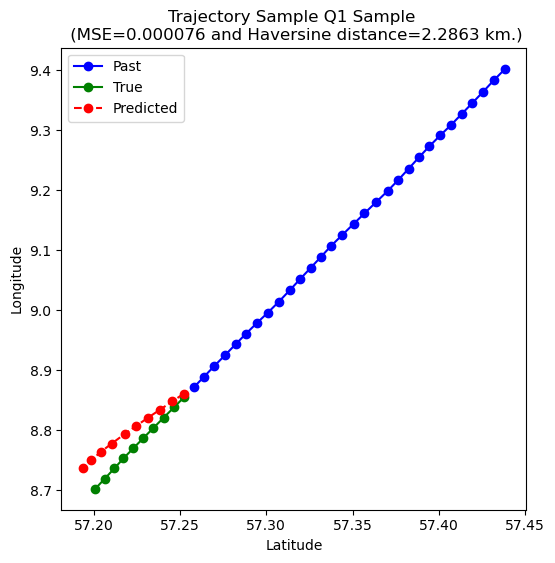

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


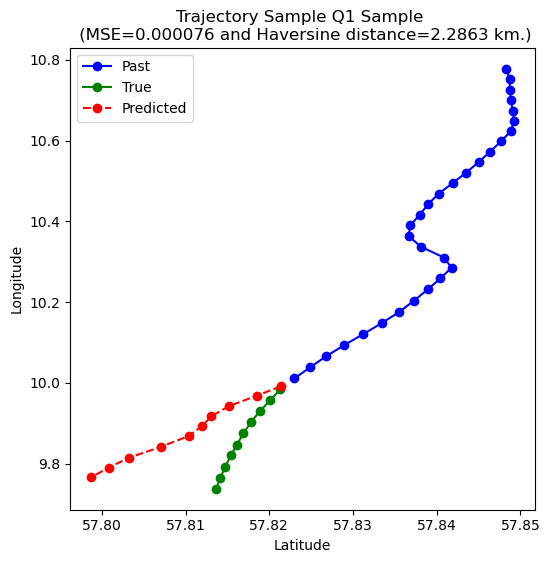

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


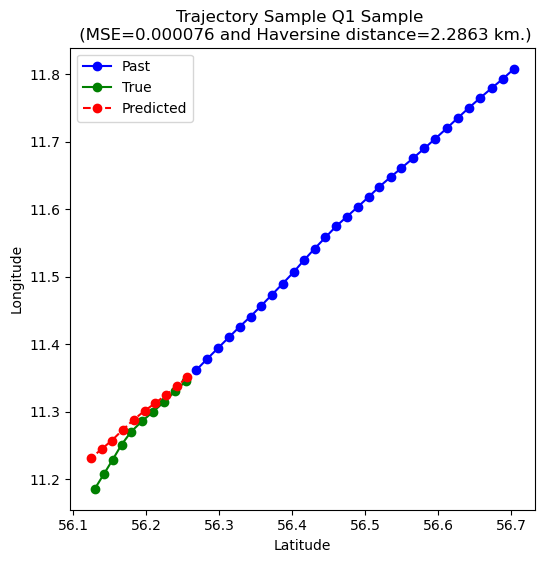

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Plotting 3 samples from Median group:


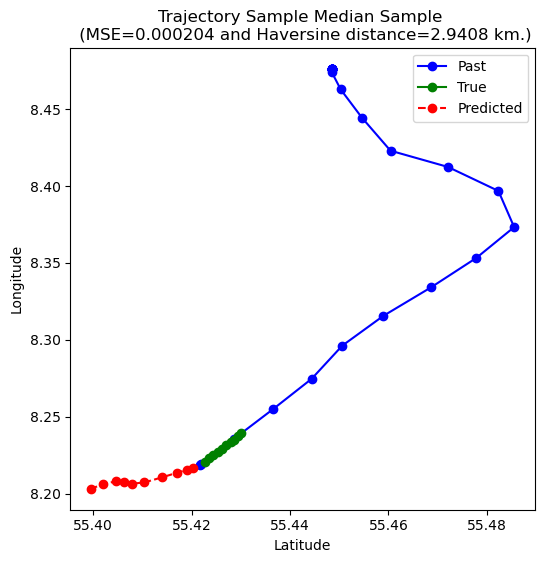

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


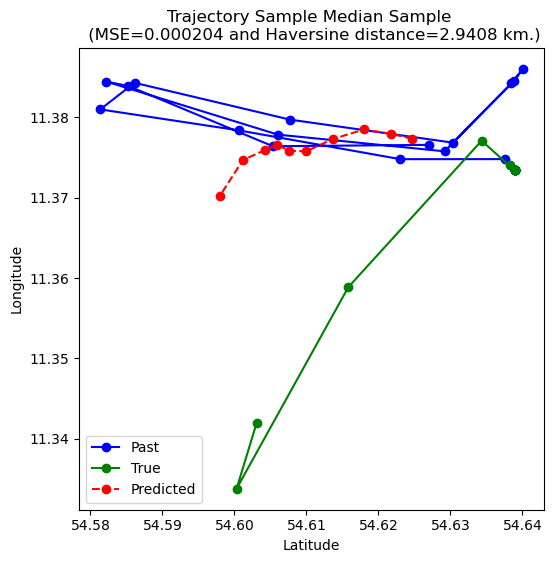

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


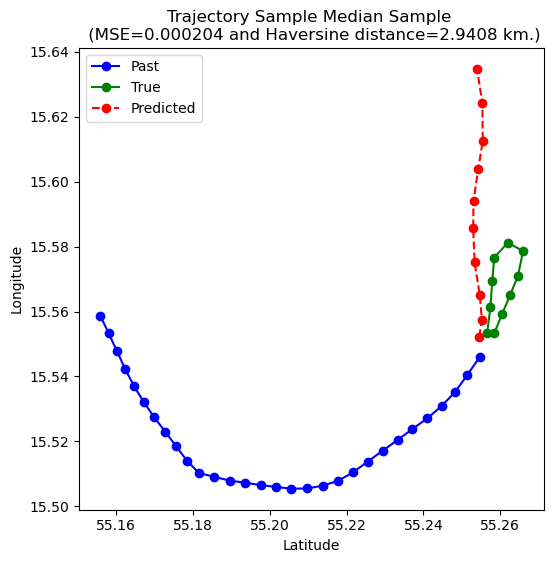

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Plotting 3 samples from Q3 group:


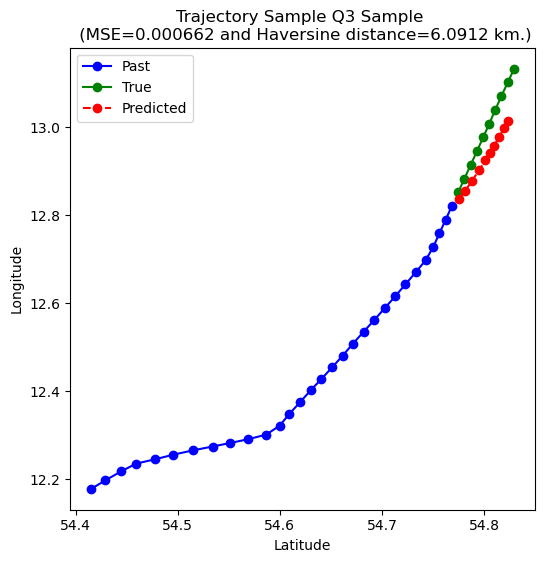

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


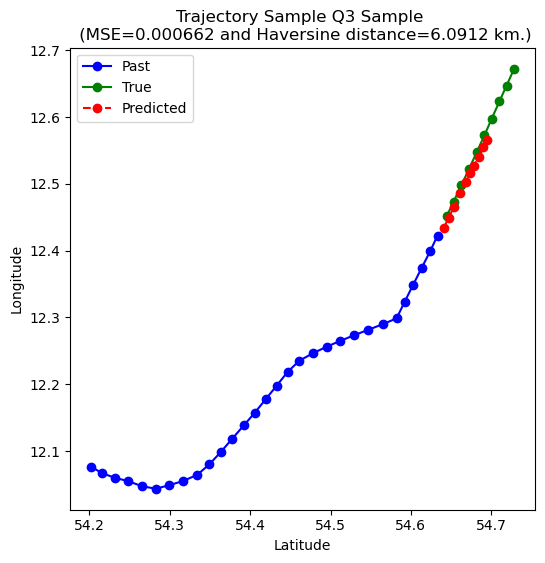

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


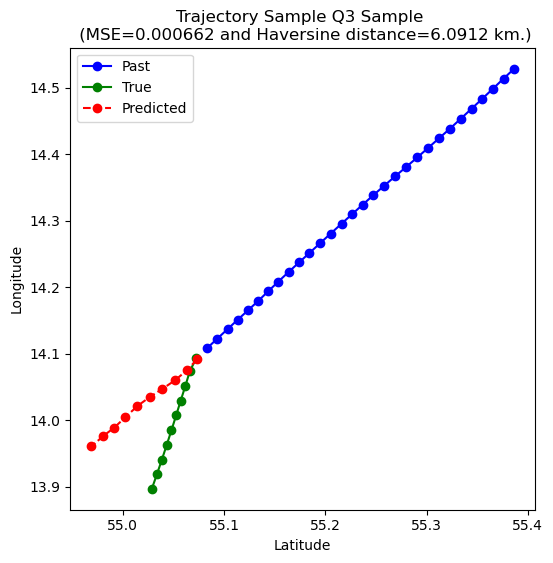


Plotting 3 samples from Worst group:


/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


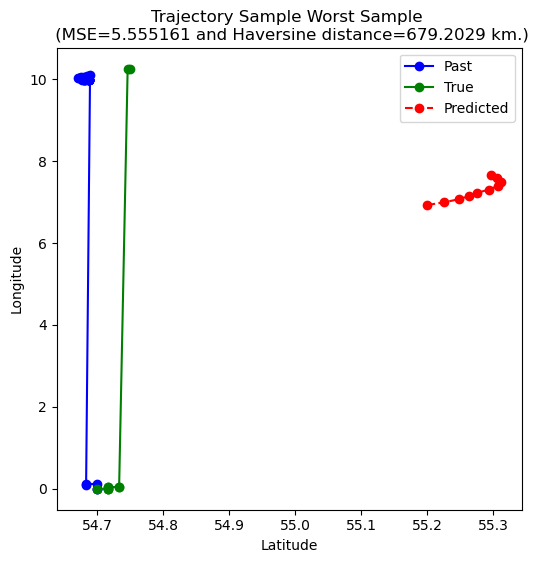

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


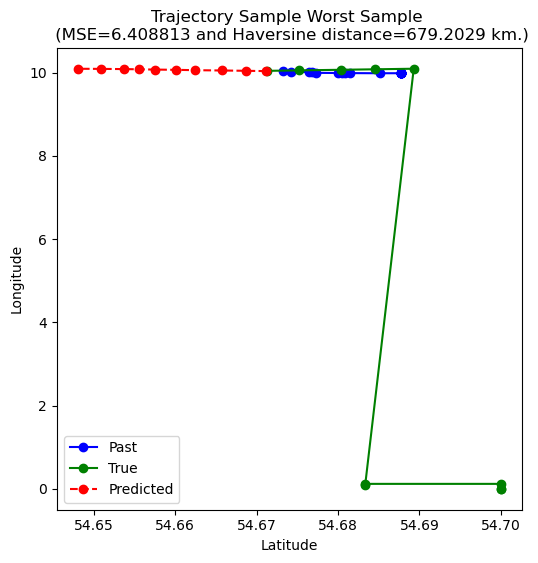

/opt/anaconda3/envs/deepl/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


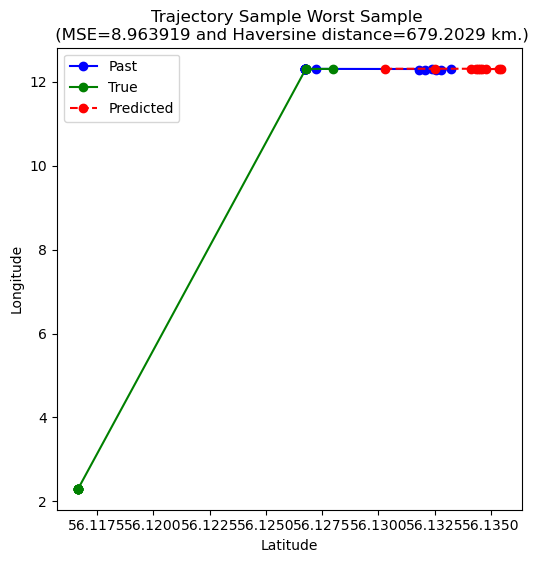

In [ ]:
# Plotting the trajectories for each group
for group_name, indices in groups.items():

    group_mean_haversine = np.mean(group_means_dict[group_name])
    print(f"\nPlotting 3 samples from {group_name} group:")
    for idx in indices:
        plot_sample(
            x=x,
            y=y,
            y_pred=y_pred,
            idx = idx,
            title= f"{group_name} Sample \n (MSE={all_mse[idx]:.6f} and Haversine distance={group_mean_haversine:.4f} km.)", filtered=True
            )